In [159]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [160]:
import matplotlib.pyplot as plt
import numpy as np
from viz_utils import *

In [161]:
import sys
import numpy as np
#import pandas as pd
import datetime
import json
from array import *
import os
import math
from random import randrange
import random

#from keras.models import Sequential
#from keras.models import model_from_json
#from keras.layers import Dense, Activation
#from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers

import tensorflow.keras as keras

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
tf.disable_v2_behavior()

In [162]:
#Classes in GAME_SOCKET_DUMMY.py
class ObstacleInfo:
    # initial energy for obstacles: Land (key = 0): -1, Forest(key = -1): 0 (random), Trap(key = -2): -10, Swamp (key = -3): -5
    types = {0: -1, -1: 0, -2: -10, -3: -5}

    def __init__(self):
        self.type = 0
        self.posx = 0
        self.posy = 0
        self.value = 0
        
class GoldInfo:
    def __init__(self):
        self.posx = 0
        self.posy = 0
        self.amount = 0

    def loads(self, data):
        golds = []
        for gd in data:
            g = GoldInfo()
            g.posx = gd["posx"]
            g.posy = gd["posy"]
            g.amount = gd["amount"]
            golds.append(g)
        return golds

class PlayerInfo:
    STATUS_PLAYING = 0
    STATUS_ELIMINATED_WENT_OUT_MAP = 1
    STATUS_ELIMINATED_OUT_OF_ENERGY = 2
    STATUS_ELIMINATED_INVALID_ACTION = 3
    STATUS_STOP_EMPTY_GOLD = 4
    STATUS_STOP_END_STEP = 5

    def __init__(self, id):
        self.playerId = id
        self.score = 0
        self.energy = 0
        self.posx = 0
        self.posy = 0
        self.lastAction = -1
        self.status = PlayerInfo.STATUS_PLAYING
        self.freeCount = 0

class GameInfo:
    def __init__(self):
        self.numberOfPlayers = 1
        self.width = 0
        self.height = 0
        self.steps = 100
        self.golds = []
        self.obstacles = []

    def loads(self, data):
        m = GameInfo()
        m.width = data["width"]
        m.height = data["height"]
        m.golds = GoldInfo().loads(data["golds"])
        m.obstacles = data["obstacles"]
        m.numberOfPlayers = data["numberOfPlayers"]
        m.steps = data["steps"]
        return m

class UserMatch:
    def __init__(self):
        self.playerId = 1
        self.posx = 0
        self.posy = 0
        self.energy = 50
        self.gameinfo = GameInfo()

    def to_json(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

class StepState:
    def __init__(self):
        self.players = []
        self.golds = []
        self.changedObstacles = []

    def to_json(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)


In [163]:
#Main class in GAME_SOCKET_DUMMY.py
class GameSocket:
    bog_energy_chain = {-5: -20, -20: -40, -40: -100, -100: -100}

    def __init__(self):
        self.stepCount = 0
        self.maxStep = 0
        self.mapdir = "Maps"  # where to load all pre-defined maps
        self.mapid = ""
        self.userMatch = UserMatch()
        self.user = PlayerInfo(1)
        self.stepState = StepState()
        self.maps = {}  # key: map file name, value: file content
        self.map = []  # running map info: 0->Land, -1->Forest, -2->Trap, -3:Swamp, >0:Gold
        self.energyOnMap = []  # self.energyOnMap[x][y]: <0, amount of energy which player will consume if it move into (x,y)
        self.E = 50
        self.resetFlag = True
        self.craftUsers = []  # players that craft at current step - for calculating amount of gold
        self.bots = []
        self.craftMap = {}  # cells that players craft at current step, key: x_y, value: number of players that craft at (x,y)

    def init_bots(self):
        self.bots = [Bot1(2), Bot2(3), Bot3(4)]  # use bot1(id=2), bot2(id=3), bot3(id=4)
        #for (bot) in self.bots:  # at the beginning, all bots will have same position, energy as player
        for bot in self.bots:  # at the beginning, all bots will have same position, energy as player
            bot.info.posx = self.user.posx
            bot.info.posy = self.user.posy
            bot.info.energy = self.user.energy
            bot.info.lastAction = -1
            bot.info.status = PlayerInfo.STATUS_PLAYING
            bot.info.score = 0
            self.stepState.players.append(bot.info)
        self.userMatch.gameinfo.numberOfPlayers = len(self.stepState.players)
        #print("numberOfPlayers: ", self.userMatch.gameinfo.numberOfPlayers)

    def reset(self, requests):  # load new game by given request: [map id (filename), posx, posy, initial energy]
        # load new map
        self.reset_map(requests[0])
        self.userMatch.posx = int(requests[1])
        self.userMatch.posy = int(requests[2])
        self.userMatch.energy = int(requests[3])
        self.userMatch.gameinfo.steps = int(requests[4])
        self.maxStep = self.userMatch.gameinfo.steps

        # init data for players
        self.user.posx = self.userMatch.posx  # in
        self.user.posy = self.userMatch.posy
        self.user.energy = self.userMatch.energy
        self.user.status = PlayerInfo.STATUS_PLAYING
        self.user.score = 0
        self.stepState.players = [self.user]
        self.E = self.userMatch.energy
        self.resetFlag = True
        self.init_bots()
        self.stepCount = 0

    def reset_map(self, id):  # load map info
        self.mapId = id
        self.map = json.loads(self.maps[self.mapId])
        self.userMatch = self.map_info(self.map)
        self.stepState.golds = self.userMatch.gameinfo.golds
        self.map = json.loads(self.maps[self.mapId])
        self.energyOnMap = json.loads(self.maps[self.mapId])
        for x in range(len(self.map)):
            for y in range(len(self.map[x])):
                if self.map[x][y] > 0:  # gold
                    self.energyOnMap[x][y] = -4
                else:  # obstacles
                    self.energyOnMap[x][y] = ObstacleInfo.types[self.map[x][y]]

    def connect(self): # simulate player's connect request
        print("Connected to server.")
        for mapid in range(len(Maps)):
            filename = "map" + str(mapid)
            print("Found: " + filename)
            self.maps[filename] = str(Maps[mapid])

    def map_info(self, map):  # get map info
        # print(map)
        userMatch = UserMatch()
        userMatch.gameinfo.height = len(map)
        userMatch.gameinfo.width = len(map[0])
        i = 0
        while i < len(map):
            j = 0
            while j < len(map[i]):
                if map[i][j] > 0:  # gold
                    g = GoldInfo()
                    g.posx = j
                    g.posy = i
                    g.amount = map[i][j]
                    userMatch.gameinfo.golds.append(g)
                else:  # obstacles
                    o = ObstacleInfo()
                    o.posx = j
                    o.posy = i
                    o.type = -map[i][j]
                    o.value = ObstacleInfo.types[map[i][j]]
                    userMatch.gameinfo.obstacles.append(o)
                j += 1
            i += 1
        return userMatch

    def receive(self):  # send data to player (simulate player's receive request)
        if self.resetFlag:  # for the first time -> send game info
            self.resetFlag = False
            data = self.userMatch.to_json()
            for (bot) in self.bots:
                bot.new_game(data)
            # print(data)
            return data
        else:  # send step state
            self.stepCount = self.stepCount + 1
            if self.stepCount >= self.maxStep:
                for player in self.stepState.players:
                    player.status = PlayerInfo.STATUS_STOP_END_STEP
            data = self.stepState.to_json()
            #for (bot) in self.bots:  # update bots' state
            for bot in self.bots:  # update bots' state
                bot.new_state(data)
            # print(data)
            return data

    def send(self, message):  # receive message from player (simulate send request from player)
        if message.isnumeric():  # player send action
            self.resetFlag = False
            self.stepState.changedObstacles = []
            action = int(message)
            # print("Action = ", action)
            self.user.lastAction = action
            self.craftUsers = []
            self.step_action(self.user, action)
            for bot in self.bots:
                if bot.info.status == PlayerInfo.STATUS_PLAYING:
                    action = bot.next_action()
                    bot.info.lastAction = action
                    # print("Bot Action: ", action)
                    self.step_action(bot.info, action)
            self.action_5_craft()
            for c in self.stepState.changedObstacles:
                self.map[c["posy"]][c["posx"]] = -c["type"]
                self.energyOnMap[c["posy"]][c["posx"]] = c["value"]

        else:  # reset game
            requests = message.split(",")
            print("Reset game: ", requests[:3], end='')
            self.reset(requests)

    def step_action(self, user, action):
        switcher = {
            0: self.action_0_left,
            1: self.action_1_right,
            2: self.action_2_up,
            3: self.action_3_down,
            4: self.action_4_free,
            5: self.action_5_craft_pre
        }
        func = switcher.get(action, self.invalidAction)
        func(user)

    def action_5_craft_pre(self, user):  # collect players who craft at current step
        user.freeCount = 0
        if self.map[user.posy][user.posx] <= 0:  # craft at the non-gold cell
            user.energy -= 10
            if user.energy <= 0:
                user.status = PlayerInfo.STATUS_ELIMINATED_OUT_OF_ENERGY
                user.lastAction = 6 #eliminated
        else:
            user.energy -= 5
            if user.energy > 0:
                self.craftUsers.append(user)
                key = str(user.posx) + "_" + str(user.posy)
                if key in self.craftMap:
                    count = self.craftMap[key]
                    self.craftMap[key] = count + 1
                else:
                    self.craftMap[key] = 1
            else:
                user.status = PlayerInfo.STATUS_ELIMINATED_OUT_OF_ENERGY
                user.lastAction = 6 #eliminated

    def action_0_left(self, user):  # user go left
        user.freeCount = 0
        user.posx = user.posx - 1
        if user.posx < 0:
            user.status = PlayerInfo.STATUS_ELIMINATED_WENT_OUT_MAP
            user.lastAction = 6 #eliminated
        else:
            self.go_to_pos(user)

    def action_1_right(self, user):  # user go right
        user.freeCount = 0
        user.posx = user.posx + 1
        if user.posx >= self.userMatch.gameinfo.width:
            user.status = PlayerInfo.STATUS_ELIMINATED_WENT_OUT_MAP
            user.lastAction = 6 #eliminated
        else:
            self.go_to_pos(user)

    def action_2_up(self, user):  # user go up
        user.freeCount = 0
        user.posy = user.posy - 1
        if user.posy < 0:
            user.status = PlayerInfo.STATUS_ELIMINATED_WENT_OUT_MAP
            user.lastAction = 6 #eliminated
        else:
            self.go_to_pos(user)

    def action_3_down(self, user):  # user go right
        user.freeCount = 0
        user.posy = user.posy + 1
        if user.posy >= self.userMatch.gameinfo.height:
            user.status = PlayerInfo.STATUS_ELIMINATED_WENT_OUT_MAP
            user.lastAction = 6 #eliminated
        else:
            self.go_to_pos(user)

    def action_4_free(self, user):  # user free
        user.freeCount += 1
        if user.freeCount == 1:
            user.energy += int(self.E / 4)
        elif user.freeCount == 2:
            user.energy += int(self.E / 3)
        elif user.freeCount == 3:
            user.energy += int(self.E / 2)
        else:
            user.energy = self.E
        if user.energy > self.E:
            user.energy = self.E

    def action_5_craft(self):
        craftCount = len(self.craftUsers)
        # print ("craftCount",craftCount)
        if (craftCount > 0):
            for user in self.craftUsers:
                x = user.posx
                y = user.posy
                key = str(user.posx) + "_" + str(user.posy)
                c = self.craftMap[key]
                m = min(math.ceil(self.map[y][x] / c), 50)
                user.score += m
                # print ("user", user.playerId, m)
            for user in self.craftUsers:
                x = user.posx
                y = user.posy
                key = str(user.posx) + "_" + str(user.posy)
                if key in self.craftMap:
                    c = self.craftMap[key]
                    del self.craftMap[key]
                    m = min(math.ceil(self.map[y][x] / c), 50)
                    self.map[y][x] -= m * c
                    if self.map[y][x] < 0:
                        self.map[y][x] = 0
                        self.energyOnMap[y][x] = ObstacleInfo.types[0]
                    for g in self.stepState.golds:
                        if g.posx == x and g.posy == y:
                            g.amount = self.map[y][x]
                            if g.amount == 0:
                                self.stepState.golds.remove(g)
                                self.add_changed_obstacle(x, y, 0, ObstacleInfo.types[0])
                                if len(self.stepState.golds) == 0:
                                    for player in self.stepState.players:
                                        player.status = PlayerInfo.STATUS_STOP_EMPTY_GOLD
                            break;
            self.craftMap = {}

    def invalidAction(self, user):
        user.status = PlayerInfo.STATUS_ELIMINATED_INVALID_ACTION
        user.lastAction = 6 #eliminated

    def go_to_pos(self, user):  # player move to cell(x,y)
        if self.map[user.posy][user.posx] == -1:
            user.energy -= randrange(16) + 5
        elif self.map[user.posy][user.posx] == 0:
            user.energy += self.energyOnMap[user.posy][user.posx]
        elif self.map[user.posy][user.posx] == -2:
            user.energy += self.energyOnMap[user.posy][user.posx]
            self.add_changed_obstacle(user.posx, user.posy, 0, ObstacleInfo.types[0])
        elif self.map[user.posy][user.posx] == -3:
            user.energy += self.energyOnMap[user.posy][user.posx]
            self.add_changed_obstacle(user.posx, user.posy, 3,
                                      self.bog_energy_chain[self.energyOnMap[user.posy][user.posx]])
        else:
            user.energy -= 4
        if user.energy <= 0:
            user.status = PlayerInfo.STATUS_ELIMINATED_OUT_OF_ENERGY
            user.lastAction = 6 #eliminated

    def add_changed_obstacle(self, x, y, t, v):
        added = False
        for o in self.stepState.changedObstacles:
            if o["posx"] == x and o["posy"] == y:
                added = True
                break
        if added == False:
            o = {}
            o["posx"] = x
            o["posy"] = y
            o["type"] = t
            o["value"] = v
            self.stepState.changedObstacles.append(o)

    def close(self):
        print("Close socket.")

In [164]:
#Bots :bot1
class Bot1:
    ACTION_GO_LEFT = 0
    ACTION_GO_RIGHT = 1
    ACTION_GO_UP = 2
    ACTION_GO_DOWN = 3
    ACTION_FREE = 4
    ACTION_CRAFT = 5

    def __init__(self, id):
        self.state = State()
        self.info = PlayerInfo(id)

    def next_action(self):
        if self.state.mapInfo.gold_amount(self.info.posx, self.info.posy) > 0:
            if self.info.energy >= 6:
                return self.ACTION_CRAFT
            else:
                return self.ACTION_FREE
        if self.info.energy < 5:
            return self.ACTION_FREE
        else:
            action = self.ACTION_GO_UP
            if self.info.posy % 2 == 0:
                if self.info.posx < self.state.mapInfo.max_x:
                    action = self.ACTION_GO_RIGHT
            else:
                if self.info.posx > 0:
                    action = self.ACTION_GO_LEFT
                else:
                    action = self.ACTION_GO_DOWN
            return action

    def new_game(self, data):
        try:
            self.state.init_state(data)
        except Exception as e:
            import traceback
            traceback.print_exc()

    def new_state(self, data):
        # action = self.next_action();
        # self.socket.send(action)
        try:
            self.state.update_state(data)
        except Exception as e:
            import traceback
            traceback.print_exc()

In [165]:
#Bots :bot2
class Bot2:
    ACTION_GO_LEFT = 0
    ACTION_GO_RIGHT = 1
    ACTION_GO_UP = 2
    ACTION_GO_DOWN = 3
    ACTION_FREE = 4
    ACTION_CRAFT = 5

    def __init__(self, id):
        self.state = State()
        self.info = PlayerInfo(id)

    def next_action(self):
        if self.state.mapInfo.gold_amount(self.info.posx, self.info.posy) > 0:
            if self.info.energy >= 6:
                return self.ACTION_CRAFT
            else:
                return self.ACTION_FREE
        if self.info.energy < 5:
            return self.ACTION_FREE
        else:
            action = np.random.randint(0, 4)            
            return action

    def new_game(self, data):
        try:
            self.state.init_state(data)
        except Exception as e:
            import traceback
            traceback.print_exc()

    def new_state(self, data):
        # action = self.next_action();
        # self.socket.send(action)
        try:
            self.state.update_state(data)
        except Exception as e:
            import traceback
            traceback.print_exc()

In [166]:
#Bots :bot3
class Bot3:
    ACTION_GO_LEFT = 0
    ACTION_GO_RIGHT = 1
    ACTION_GO_UP = 2
    ACTION_GO_DOWN = 3
    ACTION_FREE = 4
    ACTION_CRAFT = 5

    def __init__(self, id):
        self.state = State()
        self.info = PlayerInfo(id)

    def next_action(self):
        if self.state.mapInfo.gold_amount(self.info.posx, self.info.posy) > 0:
            if self.info.energy >= 6:
                return self.ACTION_CRAFT
            else:
                return self.ACTION_FREE
        if self.info.energy < 5:
            return self.ACTION_FREE
        else:
            action = self.ACTION_GO_LEFT
            if self.info.posx % 2 == 0:
                if self.info.posy < self.state.mapInfo.max_y:
                    action = self.ACTION_GO_DOWN
            else:
                if self.info.posy > 0:
                    action = self.ACTION_GO_UP
                else:
                    action = self.ACTION_GO_RIGHT            
            return action

    def new_game(self, data):
        try:
            self.state.init_state(data)
        except Exception as e:
            import traceback
            traceback.print_exc()

    def new_state(self, data):
        # action = self.next_action();
        # self.socket.send(action)
        try:
            self.state.update_state(data)
        except Exception as e:
            import traceback
            traceback.print_exc()

In [167]:
#MinerState.py
def str_2_json(str):
    return json.loads(str, encoding="utf-8")


class MapInfo:
    def __init__(self):
        self.max_x = 0 #Width of the map
        self.max_y = 0 #Height of the map
        self.golds = [] #List of the golds in the map
        self.obstacles = []
        self.numberOfPlayers = 0
        self.maxStep = 0 #The maximum number of step is set for this map

    def init_map(self, gameInfo):
        #Initialize the map at the begining of each episode
        self.max_x = gameInfo["width"] - 1
        self.max_y = gameInfo["height"] - 1
        self.golds = gameInfo["golds"]
        self.obstacles = gameInfo["obstacles"]
        self.maxStep = gameInfo["steps"]
        self.numberOfPlayers = gameInfo["numberOfPlayers"]

    def update(self, golds, changedObstacles):
        #Update the map after every step
        self.golds = golds
        for cob in changedObstacles:
            newOb = True
            for ob in self.obstacles:
                if cob["posx"] == ob["posx"] and cob["posy"] == ob["posy"]:
                    newOb = False
                    #print("cell(", cob["posx"], ",", cob["posy"], ") change type from: ", ob["type"], " -> ",
                    #      cob["type"], " / value: ", ob["value"], " -> ", cob["value"])
                    ob["type"] = cob["type"]
                    ob["value"] = cob["value"]
                    break
            if newOb:
                self.obstacles.append(cob)
                #print("new obstacle: ", cob["posx"], ",", cob["posy"], ", type = ", cob["type"], ", value = ",
                #      cob["value"])

    def get_min_x(self):
        return min([cell["posx"] for cell in self.golds])

    def get_max_x(self):
        return max([cell["posx"] for cell in self.golds])

    def get_min_y(self):
        return min([cell["posy"] for cell in self.golds])

    def get_max_y(self):
        return max([cell["posy"] for cell in self.golds])

    def is_row_has_gold(self, y):
        return y in [cell["posy"] for cell in self.golds]

    def is_column_has_gold(self, x):
        return x in [cell["posx"] for cell in self.golds]

    def gold_amount(self, x, y): #Get the amount of golds at cell (x,y)
        for cell in self.golds:
            if x == cell["posx"] and y == cell["posy"]:
                return cell["amount"]
        return 0 

    def get_obstacle(self, x, y):  # Get the kind of the obstacle at cell(x,y)
        for cell in self.obstacles:
            if x == cell["posx"] and y == cell["posy"]:
                return cell["type"]
        return -1  # No obstacle at the cell (x,y)


class State:
    STATUS_PLAYING = 0
    STATUS_ELIMINATED_WENT_OUT_MAP = 1
    STATUS_ELIMINATED_OUT_OF_ENERGY = 2
    STATUS_ELIMINATED_INVALID_ACTION = 3
    STATUS_STOP_EMPTY_GOLD = 4
    STATUS_STOP_END_STEP = 5

    def __init__(self):
        self.end = False
        self.score = 0
        self.lastAction = None
        self.id = 0
        self.x = 0
        self.y = 0
        self.energy = 0
        self.mapInfo = MapInfo()
        self.players = []
        self.stepCount = 0
        self.status = State.STATUS_PLAYING

    def init_state(self, data): #parse data from server into object
        game_info = str_2_json(data)
        self.end = False
        self.score = 0
        self.lastAction = None
        self.id = game_info["playerId"]
        self.x = game_info["posx"]
        self.y = game_info["posy"]
        self.energy = game_info["energy"]
        self.mapInfo.init_map(game_info["gameinfo"])
        self.stepCount = 0
        self.status = State.STATUS_PLAYING
        self.players = [{"playerId": 2, "posx": self.x, "posy": self.y},
                        {"playerId": 3, "posx": self.x, "posy": self.y},
                        {"playerId": 4, "posx": self.x, "posy": self.y}]

    def update_state(self, data):
        new_state = str_2_json(data)
        for player in new_state["players"]:
            if player["playerId"] == self.id:
                self.x = player["posx"]
                self.y = player["posy"]
                self.energy = player["energy"]
                self.score = player["score"]
                self.lastAction = player["lastAction"]
                self.status = player["status"]

        self.mapInfo.update(new_state["golds"], new_state["changedObstacles"])
        self.players = new_state["players"]
        for i in range(len(self.players), 4, 1):
            self.players.append({"playerId": i, "posx": self.x, "posy": self.y})
        self.stepCount = self.stepCount + 1

In [168]:
#MinerEnv.py
TreeID = 1
TrapID = 2
SwampID = 3
class MinerEnv:
    def __init__(self):
        self.socket = GameSocket()
        self.state = State()
        
        self.score_pre = self.state.score#Storing the last score for designing the reward function

    def start(self): #connect to server
        self.socket.connect()

    def end(self): #disconnect server
        self.socket.close()

    def send_map_info(self, request):#tell server which map to run
        self.socket.send(request)

    def reset(self): #start new game
        try:
            message = self.socket.receive() #receive game info from server
            self.state.init_state(message) #init state
        except Exception as e:
            import traceback
            traceback.print_exc()

    def step(self, action): #step process
        self.socket.send(action) #send action to server
        try:
            message = self.socket.receive() #receive new state from server
            self.state.update_state(message) #update to local state
        except Exception as e:
            import traceback
            traceback.print_exc()

    # Functions are customized by client
    def get_state(self):
        # Building the map
        #view = np.zeros([self.state.mapInfo.max_x + 1, self.state.mapInfo.max_y + 1], dtype=int)
        view = np.zeros([self.state.mapInfo.max_y + 1, self.state.mapInfo.max_x + 1], dtype=int)
        for x in range(self.state.mapInfo.max_x + 1):
            for y in range(self.state.mapInfo.max_y + 1):
                if self.state.mapInfo.get_obstacle(x, y) == TreeID:  # Tree
                    view[y, x] = -TreeID
                if self.state.mapInfo.get_obstacle(x, y) == TrapID:  # Trap
                    view[y, x] = -TrapID
                if self.state.mapInfo.get_obstacle(x, y) == SwampID: # Swamp
                    view[y, x] = -SwampID
                if self.state.mapInfo.gold_amount(x, y) > 0:
                    view[y, x] = self.state.mapInfo.gold_amount(x, y)

        DQNState = view.flatten().tolist() #Flattening the map matrix to a vector
        
        # Add position and energy of agent to the DQNState
        DQNState.append(self.state.x)
        DQNState.append(self.state.y)
        DQNState.append(self.state.energy)
        #Add position of bots 
        for player in self.state.players:
            if player["playerId"] != self.state.id:
                DQNState.append(player["posx"])
                DQNState.append(player["posy"])
                
        #Convert the DQNState from list to array for training
        DQNState = np.array(DQNState)

        return DQNState

    def get_reward(self):
        # Calculate reward
        reward = 0
        score_action = self.state.score - self.score_pre
        self.score_pre = self.state.score
        if score_action > 0:
            #If the DQN agent crafts golds, then it should obtain a positive reward (equal score_action)
            #reward += score_action
            reward += score_action*5
            
        ##If the DQN agent crashs into obstacels (Tree, Trap, Swamp), then it should be punished by a negative reward
        #if self.state.mapInfo.get_obstacle(self.state.x, self.state.y) == TreeID:  # Tree
        #    reward -= TreeID
        #if self.state.mapInfo.get_obstacle(self.state.x, self.state.y) == TrapID:  # Trap
        #    reward -= TrapID
        if self.state.mapInfo.get_obstacle(self.state.x, self.state.y) == SwampID:  # Swamp
            reward -= SwampID
            if self.state.lastAction == 4:
                reward -= 40

        # If out of the map, then the DQN agent should be punished by a larger nagative reward.
        if self.state.status == State.STATUS_ELIMINATED_WENT_OUT_MAP:
            #if self.state.stepCount < 50:
            #    reward += -5*(50 - self.state.stepCount)
            reward += -50
            
        #Run out of energy, then the DQN agent should be punished by a larger nagative reward.
        if self.state.status == State.STATUS_ELIMINATED_OUT_OF_ENERGY:
            if self.state.stepCount < 50:
                reward += -(50 - self.state.stepCount)
                if self.state.lastAction != 4:
                    # 4 is taking a rest
                    reward += -10
        
        # control comes to here \implies our agent is not dead yet
        if self.state.status == State.STATUS_PLAYING:
            if self.state.energy >= 45 and self.state.lastAction == 4:
                reward -= 30
        # print ("reward",reward)
        return reward

    def check_terminate(self):
        #Checking the status of the game
        #it indicates the game ends or is playing
        return self.state.status != State.STATUS_PLAYING


In [169]:
#Creating Maps
#This function is used to create 05 maps instead of loading them from Maps folder in the local
def CreateMaps():
    map0 = [
      [0,  0,  -2,  100,  0,  0,  -1,  -1,  -3,  0,  0,  0,  -1,  -1,  0,  0,  -3,  0,  -1,  -1,0],
      [-1,-1,  -2,  0, 0,  0,  -3,  -1,  0,  -2,  0,  0,  0,  -1,  0,  -1,  0,  -2,  -1,  0,0],
      [0,  0,  -1,  0,  0,  0,  0,  -1,  -1,  -1,  0, 0,  100,  0,  0,  0,  0,  50,  -2,  0,0],
      [0,  0,  0,  0,  -2,  0,  0,  0,  0,  0,  0,  0,  -1,  50, -2,  0,  0,  -1,  -1,  0,0],
      [-2, 0,  200,  -2,  -2,  300,  0, 0,  -2,  -2,  0,  0,  -3,  0,  -1,  0,  0,  -3,  -1,  0,0],
      [0,  -1,  0,  0,  0,  0,  0,  -3,  0,  0,  -1,  -1,  0,  0,  0,  0,  0,  0,  -2,  0,0],
      [0,  -1,  -1,  0,  0,  -1,  -1,  0,  0,  700,  -1,  0,  0,  0,  -2,  -1,  -1,  0,  0, 0,100],
      [0,  0, 0, 500,  0,  0,  -1,  0,  -2,  -2,  -1,  -1,  0,  0,  -2,  0,  -3,  0,  0,  -1,0],
      [-1,  -1, 0,-2 ,  0,  -1,  -2,  0,  400,  -2,  -1,  -1,  500,  0,  -2,  0,  -3,  100,  0, 0,0]
    ]
    map1 = [
      [0,  0,  -2,  0,  0,  0,  -1,  -1,  -3,  0,  0,  0,  -1,  -1,  0,  0,  -3,  0,  -1,  -1,0],
      [-1,-1,  -2,  100, 0,  0,  -3,  -1,  0,  -2,  100,  0,  0,  -1,  0,  -1,  0,  -2,  -1,  0,0],
      [0,  0,  -1,  0,  0,  0,  0,  -1,  -1,  -1,  0, 0,  0,  0,  0,  0,  50,  0,  -2,  0,0],
      [0,  200,  0,  0,  -2,  0,  0,  0,  0,  0,  0,  0,  -1,  50, -2,  0,  0,  -1,  -1,  0,0],
      [-2, 0,  0,  -2,  -2,  0,  0, 0,  -2,  -2,  0,  0,  -3,  0,  -1,  0,  0,  -3,  -1,  0,0],
      [0,  -1,  0,  0,  300,  0,  0,  -3,  0,  0,  -1,  -1,  0,  0,  0,  0,  0,  0,  -2,  0,0],
      [500,  -1,  -1,  0,  0,  -1,  -1,  0,  700,  0,  -1,  0,  0,  0,  -2,  -1,  -1,  0,  0, 0,0],
      [0,  0, 0, 0,  0,  0,  -1,  0,  -2,  -2,  -1,  -1,  0,  0,  -2,  0,  -3,  100,  0,  -1,0],
      [-1,  -1, 0,-2 ,  0,  -1,  -2,  400,  0,  -2,  -1,  -1,  0,  500,  -2,  0,  -3,  0,  0, 100,0]
    ]
    map2 = [
      [0,  0,  -2,  0,  0,  0,  -1,  -1,  -3,  0,  100,  0,  -1,  -1,  0,  0,  -3,  0,  -1,  -1,0],
      [-1,-1,  -2,  0, 0,  0,  -3,  -1,  0,  -2,  0,  0,  0,  -1,  0,  -1,  0,  -2,  -1,  0,0 ],
      [0,  0,  -1,  0,  0,  0,  100,  -1,  -1,  -1,  0, 0,  50,  0,  0,  0,  50,  0,  -2,  0,0],
      [0,  200,  0,  0,  -2,  0,  0,  0,  0,  0,  0,  0,  -1,  0, -2,  0,  0,  -1,  -1,  0,0],
      [-2, 0,  0,  -2,  -2,  0,  0, 0,  -2,  -2,  0,  0,  -3,  0,  -1,  0,  0,  -3,  -1,  0,0],
      [0,  -1,  0, 300,  0,  0,  0,  -3,  0,  0,  -1,  -1,  0,  0,  0,  0,  0,  0,  -2,  0,0],
      [0,  -1,  -1,  0,  0,  -1,  -1,  700,  0,  0,  -1,  0,  0,  0,  -2,  -1,  -1,  0,  0, 0,0],
      [0,  0, 0, 0,  0,  500,  -1,  0,  -2,  -2,  -1,  -1,  0,  0,  -2,  0,  -3,  0,  700,  -1,0],
      [-1,  -1, 0,-2 ,  0,  -1,  -2,  400,  0,  -2,  -1,  -1,  0,  500,  -2,  0,  -3,  0,  0, 100,0]
    ]
    map3 = [
      [0,  0,  -2,  0,  0,  0,  -1,  -1,  -3,  0,  0,  0,  -1,  -1,  0,  0,  -3,  0,  -1,  -1,0],
      [-1,-1,  -2,  0, 0,  0,  -3,  -1,  0,  -2,  0,  0,  100,  -1,  0,  -1,  0,  -2,  -1,  0,0],
      [0,  0,  -1,  0,  100,  0,  0,  -1,  -1,  -1,  0, 0,  0,  0,  50,  0,  50,  0,  -2,  0,0],
      [0,  200,  0,  0,  -2,  0,  0,  0,  0,  0,  0,  0,  -1,  0, -2,  0,  0,  -1,  -1,  0,0],
      [-2, 0,  0,  -2,  -2,  0,  0, 0,  -2,  -2,  0,  0,  -3,  0,  -1,  0,  0,  -3,  -1,  0,0],
      [0,  -1,  0,  0,  0,  0,  300,  -3,  0,  700,  -1,  -1,  0,  0,  0,  0,  0,  0,  -2,  0,0],
      [0,  -1,  -1,  0,  0,  -1,  -1,  0,  0,  0,  -1,  0,  0,  0,  -2,  -1,  -1,  0,  0, 100,0],
      [500,  0, 0, 0,  0,  0,  -1,  0,  -2,  -2,  -1,  -1,  0,  0,  -2,  0,  -3,  0,  0,  -1,0],
      [-1,  -1, 0,-2 ,  0,  -1,  -2,  400,  0,  -2,  -1,  -1,  0,  500,  -2,  0,  -3,  0,  0, 100,0]

    ]
    map4 = [
      [0,  0,  -2,  0,  100,  0,  -1,  -1,  -3,  0,  0,  0,  -1,  -1,  0,  0,  -3,  0,  -1,  -1,0],
      [-1,-1,  -2,  0, 0,  0,  -3,  -1,  0,  -2,  100,  0,  0,  -1,  0,  -1,  0,  -2,  -1,  0,0],
      [0,  0,  -1,  0,  0,  0,  0,  -1,  -1,  -1,  0, 0,  0,  0,  50,  0,  0,  0,  -2,  0,0],
      [0,  200,  0,  0,  -2,  0,  0,  0,  0,  0,  0,  0,  -1,  0, -2,  0,  50,  -1,  -1,  0,0],
      [-2, 0,  0,  -2,  -2,  0,  0, 0,  -2,  -2,  0,  0,  -3,  0,  -1,  0,  0,  -3,  -1,  0,0],
      [0,  -1,  0,  0,  300,  0,  0,  -3,  0,  0,  -1,  -1,  0,  0,  0,  0,  0,  0,  -2,  0,0],
      [500,  -1,  -1,  0,  0,  -1,  -1,  0,  0,  700,  -1,  0,  0,  0,  -2,  -1,  -1,  0,  0, 100,0],
      [0,  0, 0, 0,  0,  0,  -1,  0,  -2,  -2,  -1,  -1,  0,  0,  -2,  0,  -3,  0,  0,  -1,0],
      [-1,  -1, 0,-2 ,  0,  -1,  -2,  400,  0,  -2,  -1,  -1,  0,  500,  -2,  0,  -3,  0,  0, 100,0]
    ]
    Maps = (map0,map1,map2,map3,map4)
    return Maps

In [170]:
game_over_reason = (
    "playing",
    "went_out_map",
    "out_of_energy",
    "invalid_action",
    "no_more_gold",
    "no_more_step",
)

## Start Playing

In [171]:
MAP_MAX_X = 21
MAP_MAX_Y = 9

In [172]:
Maps = CreateMaps()
minerEnv = MinerEnv()
minerEnv.start()
mapID = np.random.randint(0, 5)
mapID = 1
posID_x = np.random.randint(MAP_MAX_X) 
posID_y = np.random.randint(MAP_MAX_Y)

request = ("map" + str(mapID) + "," + str(posID_x) + "," + str(posID_y) + ",50,100") 
minerEnv.send_map_info(request)

minerEnv.reset()
s = minerEnv.get_state()
carte = s[:-9].reshape(MAP_MAX_Y, MAP_MAX_X)
carte

Connected to server.
Found: map0
Found: map1
Found: map2
Found: map3
Found: map4
Reset game:  ['map1', '10', '4']

array([[  0,   0,  -2,   0,   0,   0,  -1,  -1,  -3,   0,   0,   0,  -1,
         -1,   0,   0,  -3,   0,  -1,  -1,   0],
       [ -1,  -1,  -2, 100,   0,   0,  -3,  -1,   0,  -2, 100,   0,   0,
         -1,   0,  -1,   0,  -2,  -1,   0,   0],
       [  0,   0,  -1,   0,   0,   0,   0,  -1,  -1,  -1,   0,   0,   0,
          0,   0,   0,  50,   0,  -2,   0,   0],
       [  0, 200,   0,   0,  -2,   0,   0,   0,   0,   0,   0,   0,  -1,
         50,  -2,   0,   0,  -1,  -1,   0,   0],
       [ -2,   0,   0,  -2,  -2,   0,   0,   0,  -2,  -2,   0,   0,  -3,
          0,  -1,   0,   0,  -3,  -1,   0,   0],
       [  0,  -1,   0,   0, 300,   0,   0,  -3,   0,   0,  -1,  -1,   0,
          0,   0,   0,   0,   0,  -2,   0,   0],
       [500,  -1,  -1,   0,   0,  -1,  -1,   0, 700,   0,  -1,   0,   0,
          0,  -2,  -1,  -1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  -1,   0,  -2,  -2,  -1,  -1,   0,
          0,  -2,   0,  -3, 100,   0,  -1,   0],
       [ -1,  -1,   0,  

In [173]:
from constants import width, height, terrain_ids

bot 0 at [10  4]
bot 1 at [10  4]
bot 2 at [10  4]


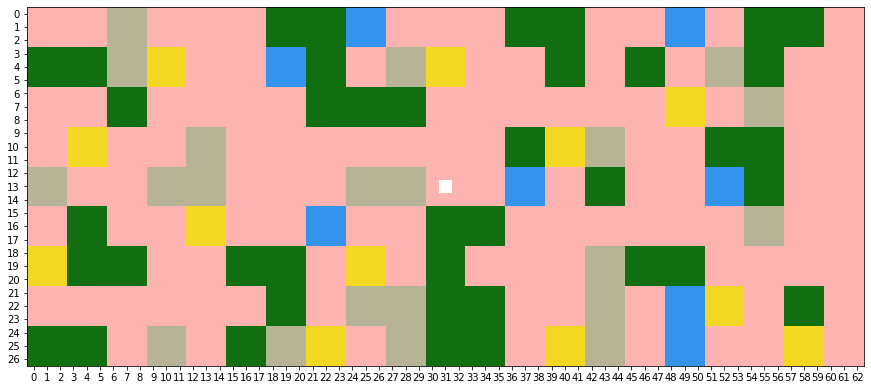

In [174]:
from viz_utils import *
imshow(prettier_render(s), figsize=(15,15))

In [175]:
from viz_utils import *

In [176]:
available_actions = {
    "up": '2',
    "down": '3',
    "left": '0',
    "right": '1',
    "rest": '4',
    "dig": '5',
}

bot 0 at [17  3]
bot 1 at [8 7]
bot 2 at [9 4]
energy = -4
terminate = True
gold = 250
step = 30


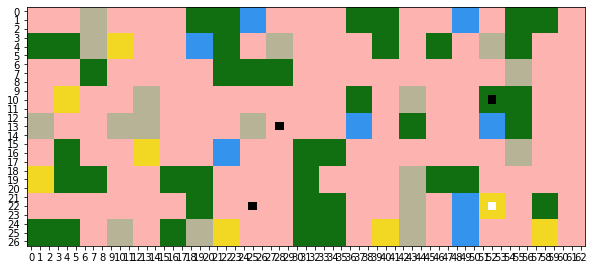

In [206]:
minerEnv.step(available_actions["dig"])
s = minerEnv.get_state()
imshow(prettier_render(s), figsize=(10,10))
#carte = s[:-9].reshape((MAP_MAX_Y, MAP_MAX_X), order='F')
energy = s[-7]
terminate = minerEnv.check_terminate()
gold = minerEnv.state.score
#print(f"carte = \n{carte}")
#print(f"position = {position}")
print(f"energy = {energy}")
print(f"terminate = {bool(terminate)}")
print(f"gold = {gold}")
print(f"step = {minerEnv.state.stepCount}")

bot 0 at [4 3]
bot 1 at [21  3]
bot 1 fell OUT OF MAP
bot 2 at [19  0]
energy = 20
terminate = True
gold = 1950
step = 100


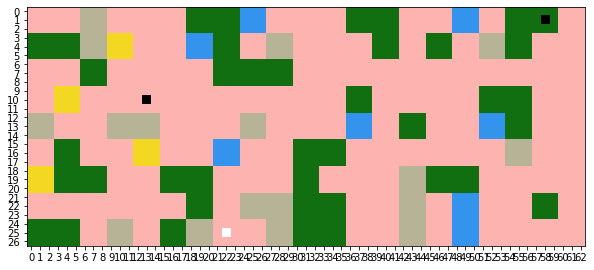

In [128]:
minerEnv.step(available_actions["dig"])
s = minerEnv.get_state()
imshow(prettier_render(s), figsize=(10,10))
#carte = s[:-9].reshape((MAP_MAX_Y, MAP_MAX_X), order='F')
energy = s[-7]
terminate = minerEnv.check_terminate()
gold = minerEnv.state.score
#print(f"carte = \n{carte}")
#print(f"position = {position}")
print(f"energy = {energy}")
print(f"terminate = {bool(terminate)}")
print(f"gold = {gold}")
print(f"step = {minerEnv.state.stepCount}")